- Feature engineer: 
   - Flagging holiday
   - Time series feature engineer from sales
- Checking feature correlation
- 52 features


In [1]:
import glob
from os import getcwd
import os
import pandas as pd
import numpy as np
import pickle
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
from statsmodels.tsa.api import SimpleExpSmoothing
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.seasonal import STL
from feature_engine.creation import CyclicalFeatures
from feature_engine.datetime import DatetimeFeatures
from feature_engine.imputation import DropMissingData
from feature_engine.selection import DropFeatures
from sktime.transformations.series.summarize import WindowSummarizer
from sklearn.pipeline import Pipeline

In [3]:
from pandas.tseries.holiday import (
    Holiday,
    AbstractHolidayCalendar, # provides all the necessary methods to return a list of holidays
    nearest_workday, # rule
    GoodFriday,
    EasterMonday)

In [4]:
# get working directory
path = os.path.dirname(getcwd())
os.chdir(path)

In [5]:

# Flagging holiday
def flagHoliday(dt):
   dt = dt.copy()
   #fiting holiday into calendar
   nl_holidays = cal.holidays(dt.index.min(), dt.index.max())
   dt["holidays"] = np.where(dt.index.isin(nl_holidays),1,0)
   return  dt


##### Engineer timeseries feature from sales

In [6]:
def decomposing(dt):
   res = STL(endog = dt['sales'],
            period = 7, 
            seasonal = 7, 
            seasonal_deg = 0,
            robust = True).fit()
   ts= {'trend': res.trend, 'seasonal': res.seasonal, 'resid': res.resid}
   ix = res.trend.index
   result = pd.DataFrame(ts, index = ix).shift(periods=1)
   newdt = result.join(dt, how = 'left')
   return newdt

In [7]:
def get_alpha(dt):
   temp  = SimpleExpSmoothing(dt['sales']).fit(optimized = True)
   alpha = temp.params['smoothing_level']
   return alpha
def exp_weighted(dt, traindt):
   alpha = get_alpha(traindt)
   result = (dt['sales'].ewm(alpha = alpha)
                        .agg(['mean', 'std'])
                        .shift(periods = 1))
   result = result.add_prefix('sales_ewm_')
   newdt = result.join(dt, how = 'left')
   return newdt


In [8]:
# Weight penalty function (linear weighted)
#mean weight scaler
def weighted_mean3(x):
    weights = np.arange(1, 3+1)  #ranking [1,2,3]
    return (weights * x).sum() / weights.sum()

def weighted_mean7(x):
    weights = np.arange(1, 7+1)  # Ranking [1,2,...,7]
    return (weights * x).sum() / weights.sum()


# std weight scaler
def weighted_std3(x):
    weights = np.arange(1, 3 +1)
    mean_w = weighted_mean3(x)
    var_w = (weights * (x - mean_w)**2).sum() / weights.sum()
    return np.sqrt(var_w)

def weighted_std7(x):
    weights = np.arange(1, 7 +1)
    mean_w = weighted_mean7(x)
    var_w = (weights * (x - mean_w)**2).sum() / weights.sum()
    return np.sqrt(var_w)




In [9]:
# pipeline to transform timeseries sales data
def getpipe():
   datetimeF = DatetimeFeatures(
      variables="index",
      features_to_extract=["weekend", #keep
                           #drop after cyclical transformer
                           "week",
                           "month",
                           "day_of_week"] )

   sincos = CyclicalFeatures(variables = sincos_cycle, 
                           drop_original = True)
   #normal window and lag
   winflagf = WindowSummarizer(
      lag_feature = {'lag':lagwindows,
                     'mean' : rollingwidow,
                     'max' :rollingwidow,
                     'min': [[1,3]],
                     'std' : rollingwidow,
                     weighted_mean3: [[1,3]],
                     weighted_mean7: [[1,7]],
                     weighted_std3: [[1,3]],
                     weighted_std7: [[1,7]],},
      target_cols = features_to_lag )

   imputer = DropMissingData()
   pipe = Pipeline([("datetime_features", datetimeF),
                  ('periodic', sincos),
                  ("lag_win_f", winflagf),
                  ("dropna", imputer),])
   return pipe



##### Set up rules to build feature

In [10]:
# Manual set holiday in the Netherlands
class NLHolidays(AbstractHolidayCalendar):
    rules = [
        GoodFriday,
        EasterMonday,
        Holiday("New Year's Day", month=1, day=1, observance=nearest_workday),
        Holiday("Kings Day", month=4, day=27),
        Holiday('Christmas', month=12, day=25),
        Holiday('Boxing day', month=12, day=26,observance=nearest_workday),  
    ]
cal = NLHolidays()

# Timeseries features 
features_to_lag = ['sales'] #only use sales data for lag features
sincos_cycle = ["week", "month", "day_of_week"] #cyclical feature to roll
lagwindows = np.arange(1,29) # window for lag from 1 to 28
# rolling window structure
shift = np.ones(2,dtype=np.int8)
rollingsize = np.array([3,7]) #window 3,7
rollingwidow =np.vstack((shift, rollingsize)).T


##### Transform data

In [11]:
def transformdata(dt, features_to_lag, traindt):
   dt = flagHoliday(dt)
   dt = decomposing(dt)
   dt = exp_weighted(dt,traindt)
   pipe = getpipe()
   result = pipe.fit_transform(dt)
   return result


   

#### Transform data to get feature and save

In [12]:

df_train = pd.read_pickle('data/2-train.pkl')
df_train2 = pd.read_pickle('data/2-train2.pkl')
df_test = pd.read_pickle('data/2-test.pkl') 
# Transform training data
# Processing data - get new feature dataframe
ip_train = transformdata(df_train,features_to_lag, df_train)
ip_train2 = transformdata(df_train2,features_to_lag, df_train2)
# target - drop index that was dropped during tranformation (sync with feature input)
target_train = df_train[['sales']].copy()
target_train = target_train.loc[ip_train.index]
target_train2 = df_train2[['sales']].copy()
target_train2 = target_train2.loc[ip_train2.index]

# transform test data
# Processing data - get new feature dataframe
df_train_comb = pd.concat([df_train, df_train2]).reset_index()
ip_test = transformdata(df_test,features_to_lag, df_train)
# target - drop index that was dropped during tranformation (sync with feature input)
target_test = df_test[['sales']].copy()
target_test = target_test.loc[ip_test.index]

ip_train.shape, ip_train2.shape, ip_test.shape

((628, 52), (110, 52), (104, 52))

In [13]:
iptrain_comb = pd.concat([ip_train, ip_train2])
tartrain_comb  = pd.concat([target_train, target_train2])
iptrain_comb.shape

(738, 52)

In [14]:
# transform
def normalize(train, test):
   sincos_fea_name = train.loc[:,train.columns.str.contains('sin|cos')].columns
   scaled_fea_name = [i for i in train.columns if i not in sincos_fea_name]
   # train data
   scaler = StandardScaler()
   scal_fea = train.loc[:, scaled_fea_name]
   scal_fea_tf = scaler.fit_transform(scal_fea)
   sincos_fea = np.array(train.loc[:, sincos_fea_name])
   xtrain_tf = np.hstack((scal_fea_tf, sincos_fea))

   # test dat
   scal_fea_test = test.loc[:, scaled_fea_name]
   scal_fea_test_tf = scaler.transform(scal_fea_test)
   sincos_fea_test = np.array(test.loc[:, sincos_fea_name])
   xtest_tf = np.hstack((scal_fea_test_tf, sincos_fea_test))
   return xtrain_tf, xtest_tf



In [15]:
xtrain_tf, xtest_tf = normalize(iptrain_comb, ip_test)
traindt_tf = (xtrain_tf, np.ravel(tartrain_comb,'C'))
testdt_tf = (xtest_tf, np.ravel(target_test,'C'))

with open("data/full_features/manual-pick/traindt-tf.pkl", 'wb') as f:
    pickle.dump(file=f, obj=traindt_tf)

with open("data/full_features/manual-pick/testdt-tf.pkl", 'wb') as f:
    pickle.dump(file=f, obj=testdt_tf)

with open("data/full_features/manual-pick/traindt.pkl", 'wb') as f:
    pickle.dump(file=f, obj=(iptrain_comb, tartrain_comb))

with open("data/full_features/manual-pick/testdt.pkl", 'wb') as f:
    pickle.dump(file=f, obj=(ip_test, target_test))

Exploring feature correlation

correlation matrix

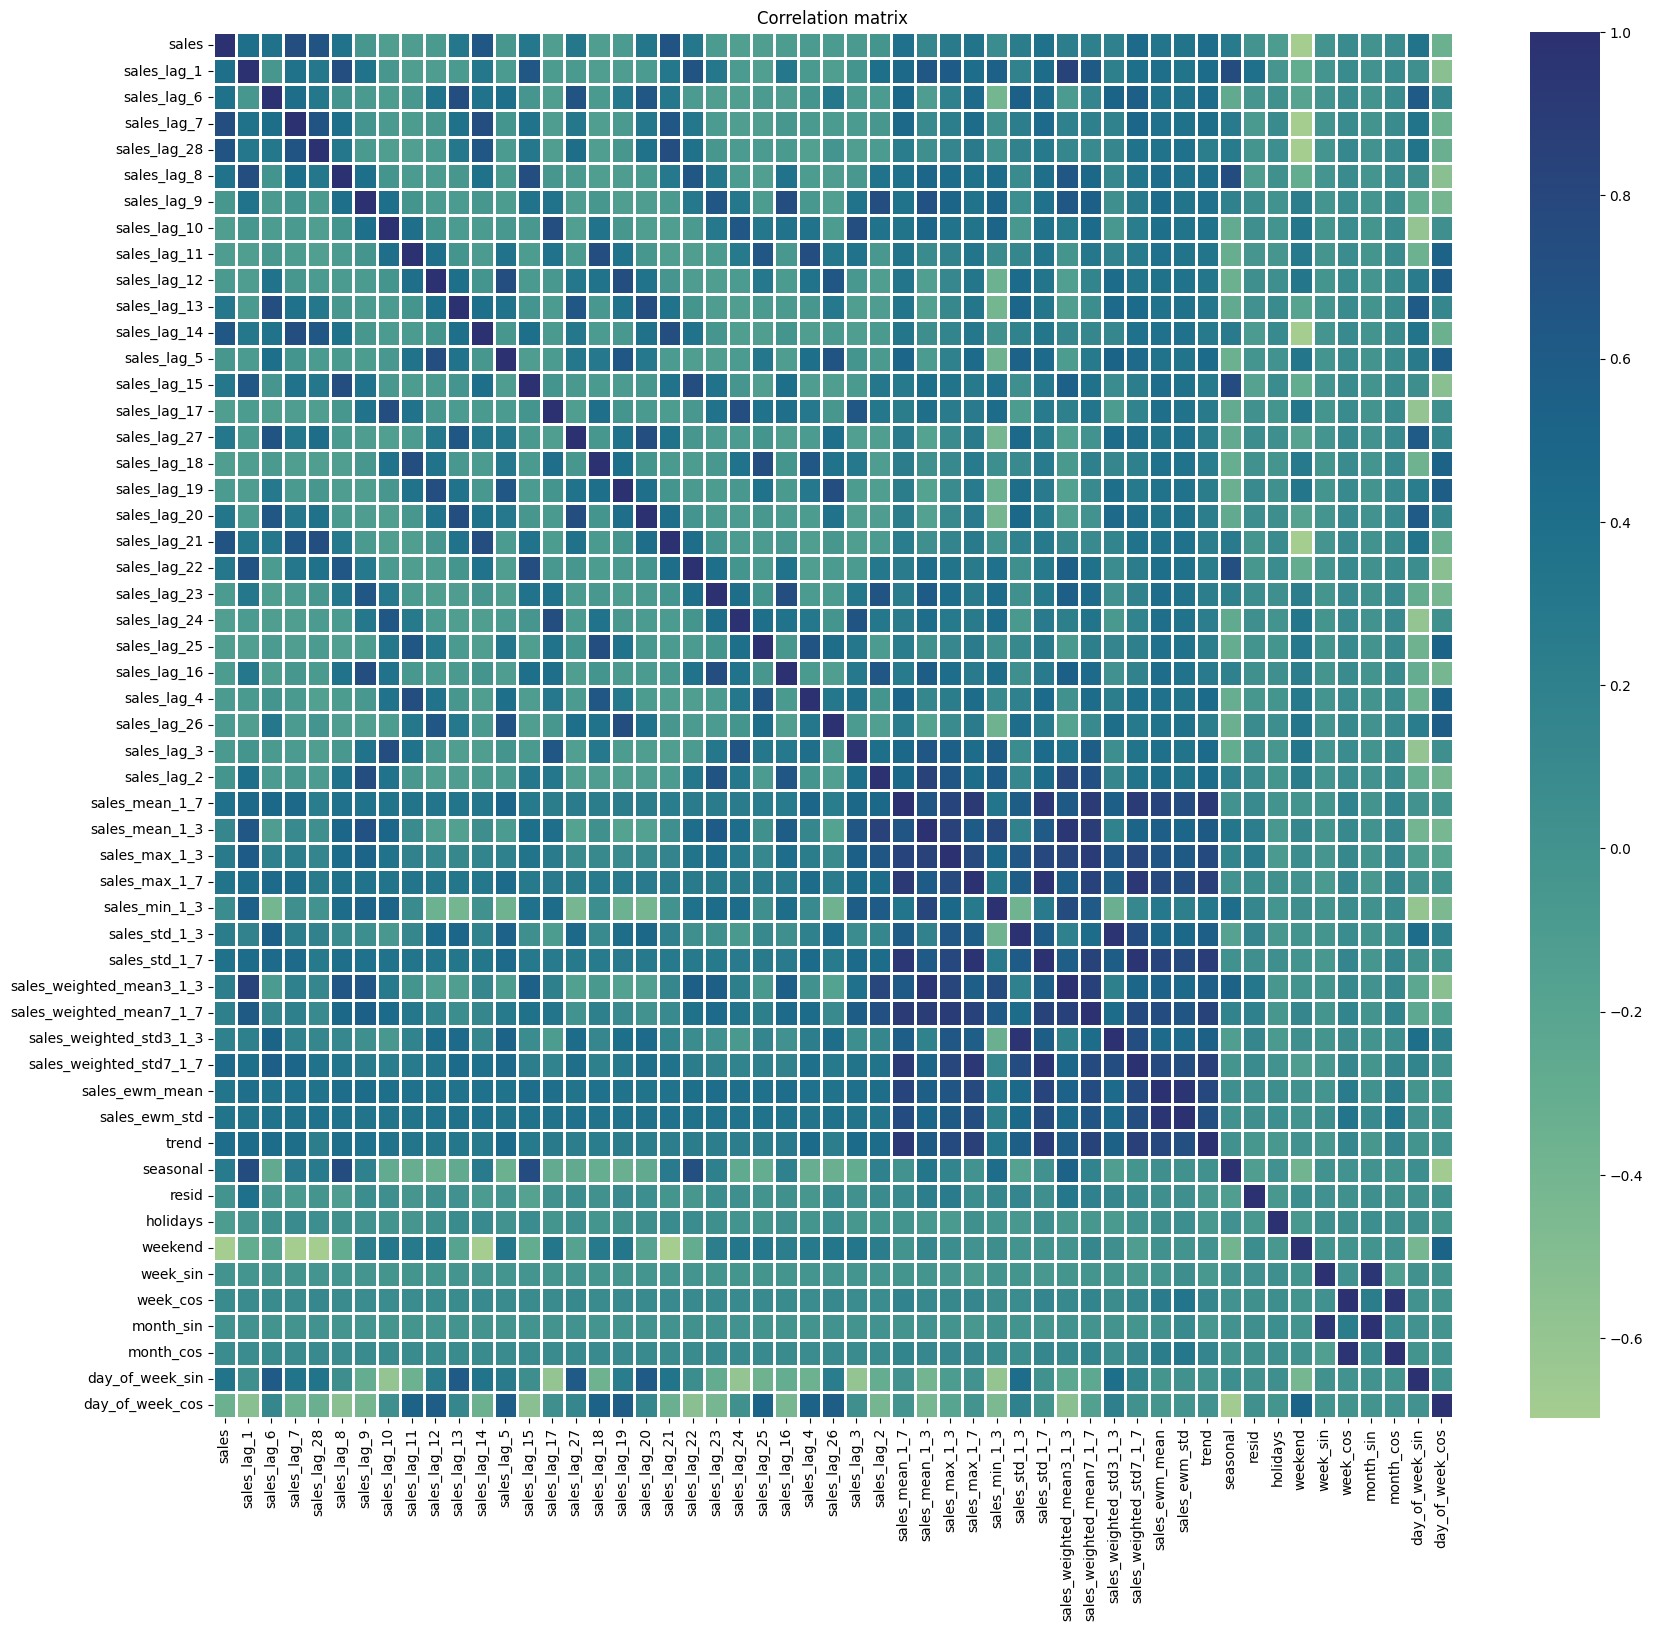

In [16]:
test_corr_df = tartrain_comb.join(iptrain_comb, how = 'right')
corr_matrix = test_corr_df.reset_index().drop('Date', axis = 1).corr()
plt.figure(figsize=(20,18))
sns.heatmap(corr_matrix,annot=False,linewidth=.9,cmap='crest')
plt.title("Correlation matrix")
plt.show()

Correlation of lag feature of sales

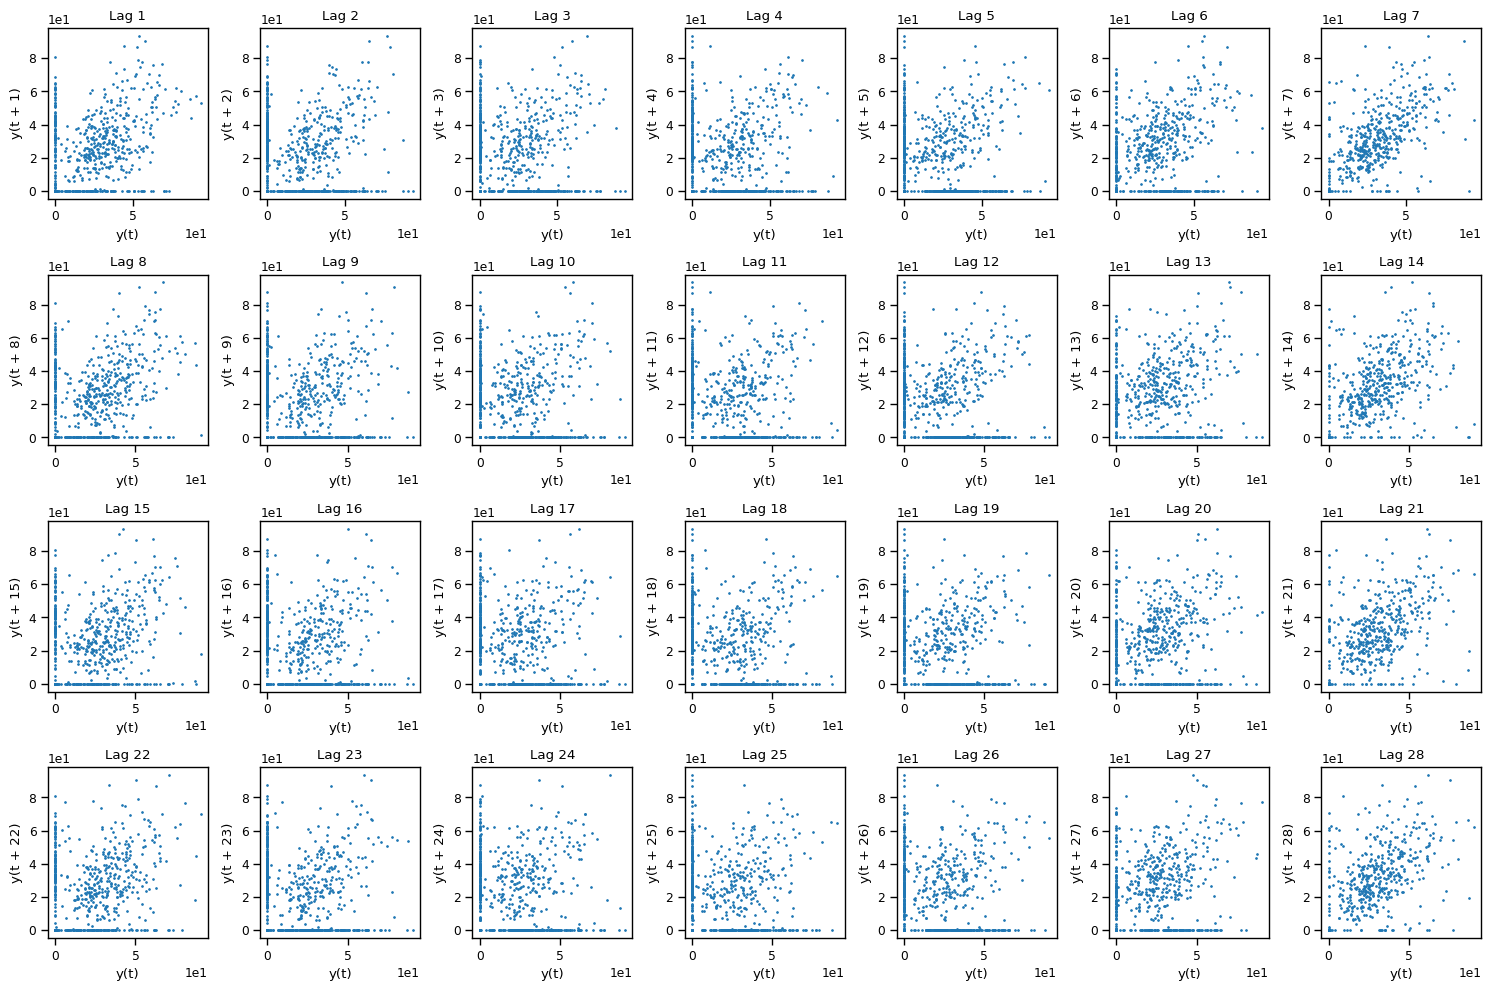

In [17]:
lags = np.arange(1,29)
with sns.plotting_context("paper"): # Sets the plotting format for these specific plots.
    fig, ax = plt.subplots(nrows=4, ncols=7, figsize=[15, 10])
    ax = ax.flatten()
    for i, lag in enumerate(lags):
        pd.plotting.lag_plot(target_train["sales"], lag=lag, ax=ax[i], marker = '.', s=5)
        ax[i].set_title(f"Lag {lag}")
        ax[i].ticklabel_format(style="sci", scilimits=(0, 0))
    plt.tight_layout()

In [18]:
res = STL(endog = df_train['sales'],
         period = 7, 
         seasonal = 7, 
         seasonal_deg = 0,
         robust = True).fit()

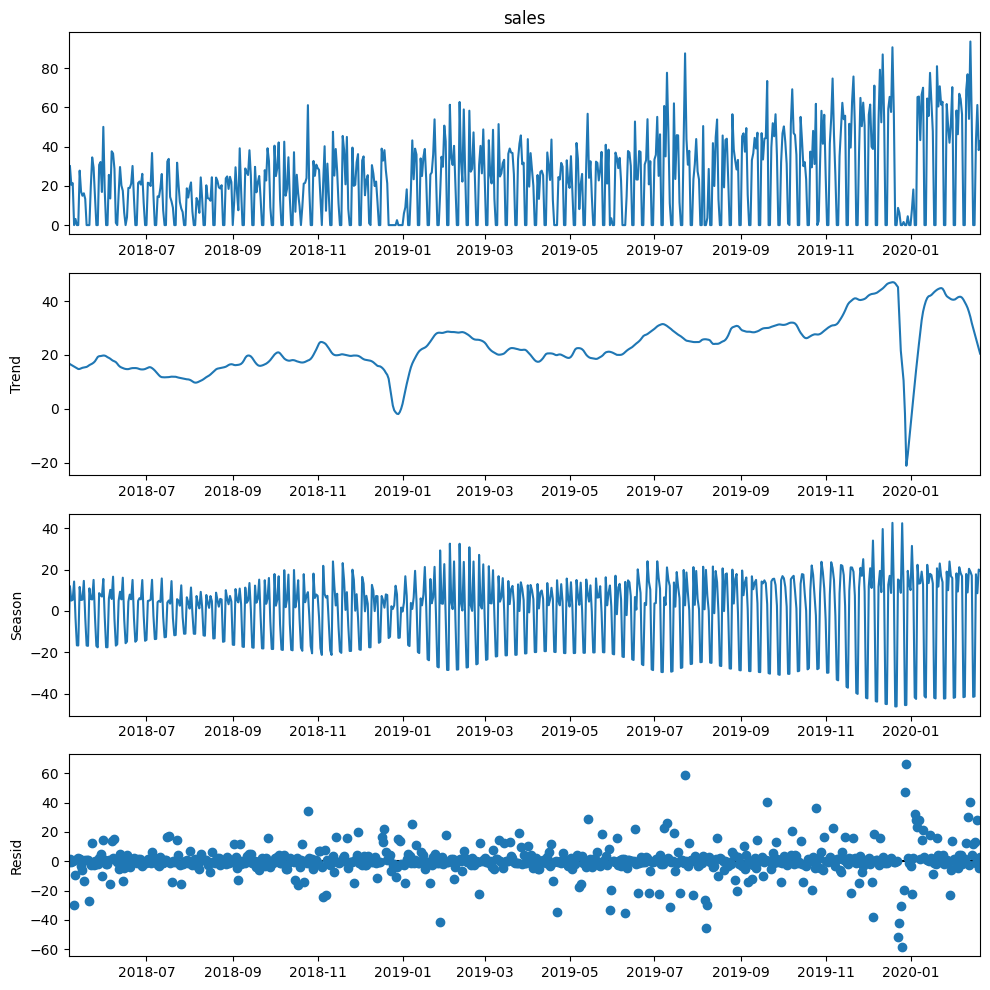

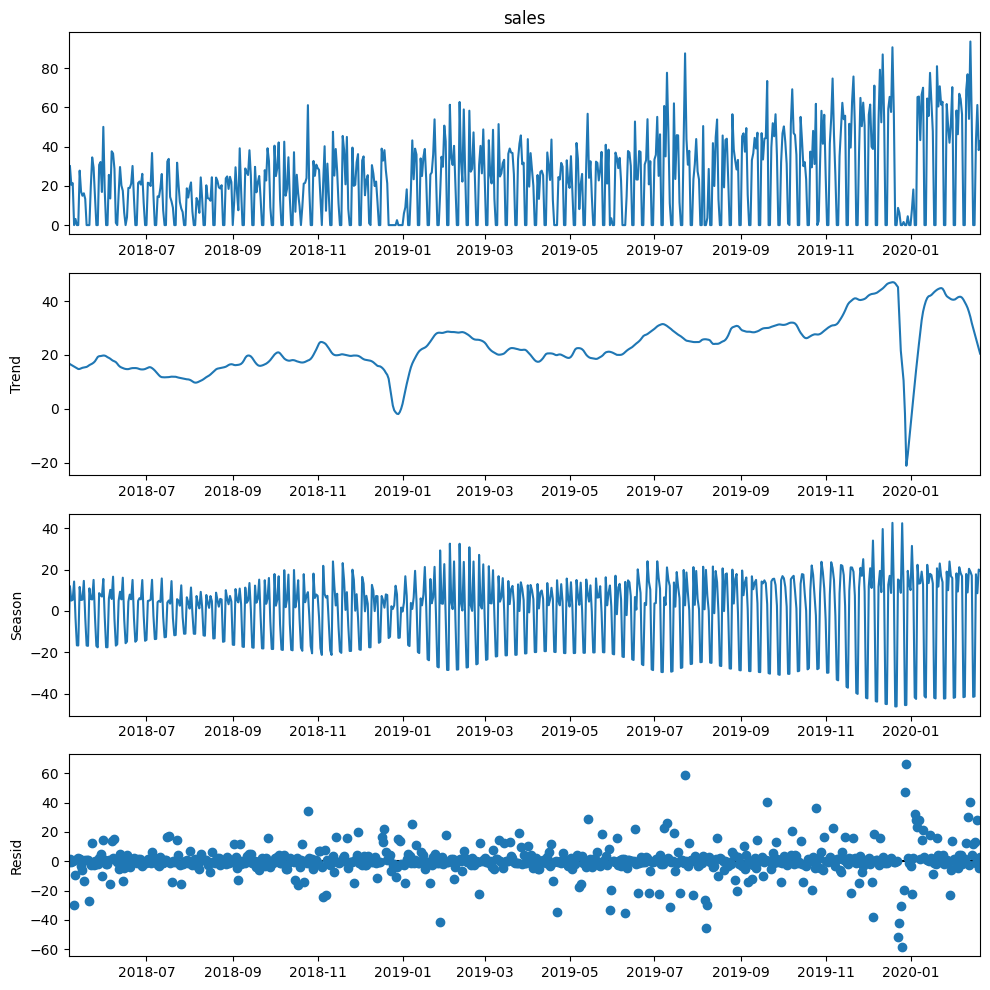

In [19]:
plt.rc('figure', figsize = (10,10))
plt.rc('font', size  = 10)
res.plot()